In [259]:
#Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [322]:
from pathlib import Path
data_dir = Path("/content/drive/My Drive/datasets")

In [323]:
#Set Working Directory
train_dir = data_dir / "train" # training_set contains training dataset
test_dir = data_dir / "test"  #contains test dataset
val_dir = data_dir / "val"  #contains val dataset

In [262]:
import torch
from torch import nn

import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [263]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [324]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [325]:
walk_through_dir(data_dir)

There are 3 directories and 0 images in '/content/drive/My Drive/datasets'.
There are 0 directories and 500 images in '/content/drive/My Drive/datasets/test'.
There are 2 directories and 0 images in '/content/drive/My Drive/datasets/val'.
There are 0 directories and 3 images in '/content/drive/My Drive/datasets/val/cat'.
There are 0 directories and 4 images in '/content/drive/My Drive/datasets/val/dog'.
There are 2 directories and 0 images in '/content/drive/My Drive/datasets/train'.
There are 0 directories and 10000 images in '/content/drive/My Drive/datasets/train/cat'.
There are 0 directories and 5998 images in '/content/drive/My Drive/datasets/train/dog'.


In [326]:
test_dir, val_dir

(PosixPath('/content/drive/My Drive/datasets/test'),
 PosixPath('/content/drive/My Drive/datasets/val'))

Random image path: /content/drive/My Drive/datasets/train/dog/dog.2865.jpg
Image class: dog
Image height: 190
Image width: 239


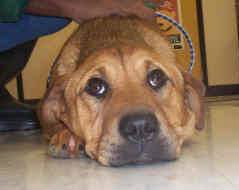

In [327]:
import random
from pathlib import Path
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(data_dir.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

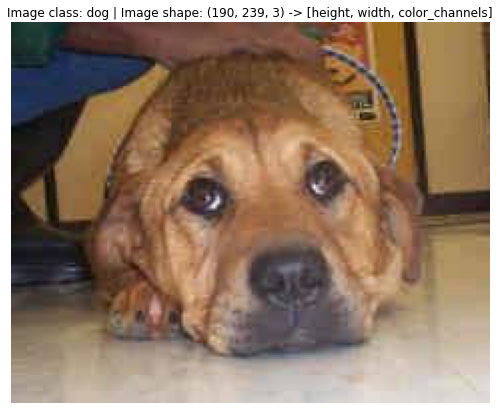

In [328]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [329]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [330]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.Resize((204,204)),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0),(1, 1, 1))
    ])

val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((204,204)),
        transforms.Normalize((0, 0, 0),(1, 1, 1))
    ])



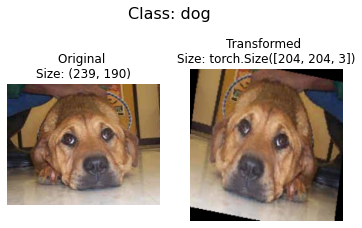

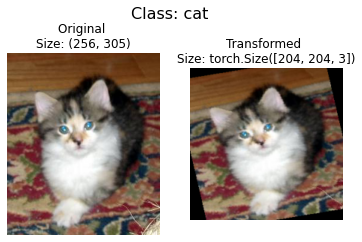

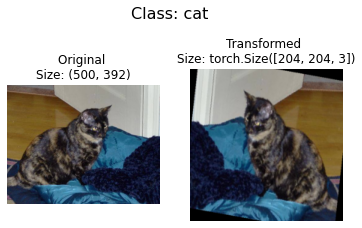

In [331]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=train_transform, 
                        n=3)

In [332]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

val_data = datasets.ImageFolder(root=val_dir, 
                                 transform=val_transform)

print(f"Train data:\n{train_data}\nTest data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 15998
    Root location: /content/drive/My Drive/datasets/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(204, 204), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0, 0, 0), std=(1, 1, 1))
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 7
    Root location: /content/drive/My Drive/datasets/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(204, 204), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=(0, 0, 0), std=(1, 1, 1))
           )


In [333]:
# Get class names as a list
class_names = train_data.classes
class_names

['cat', 'dog']

In [334]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_data, 
                             batch_size=32, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f6e47dfe410>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6e47dfe210>)

In [335]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 204, 204]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


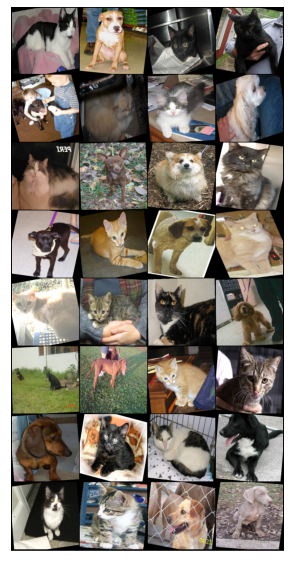

In [336]:
for images, labels in train_dataloader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [320]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    #acc = np.sum(acc) / len(preds)
    
    return acc

In [342]:
def train_one_epoch(train_dataloader):
    
    ### Local Parameters
    epoch_start_time = time.time()
    train_acc =0.0
    train_loss = 0.0
    model.train()
    
    ###Iterating over data loader
    for images, labels in train_dataloader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device, dtype=torch.float)
        labels = labels.reshape((labels.shape[0], 1))
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward Pass
        preds = model(images)
        
        #Calculating Loss
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        #train_acc +=np.sum(np.argmax(preds.cpu().data.numpy(),axis=1)== labels.cpu().numpy())
        train_acc += accuracy(preds, labels)
       
        train_loss +=loss.item()
        #print(train_acc)
        
            ###Overall Epoch Results
    model.eval()    
    with torch.no_grad():
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_data.__len__(), train_loss/train_data.__len__()))
    

In [283]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

In [284]:
# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

#Loss Function
criterion = nn.BCELoss()

# Loading model to device
model.to(device)

# No of epochs 
epochs = 1

In [343]:
def val_one_epoch(val_data_loader):
    
    ### Local Parameters
    epoch_start_time = time.time()
    best_val_acc=0.0
    val_acc =0.0
    val_loss = 0.0
    model.eval()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
         #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device, dtype=torch.float)
        labels = labels.reshape((labels.shape[0], 1))
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward Pass
        preds = model(images)
        
        #Calculating Loss
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        #val_acc +=np.sum(np.argmax(preds.cpu().data.numpy(),axis=1)== labels.cpu().numpy())
        val_loss +=loss.item()
        val_acc += accuracy(preds, labels)
        
    
    ###Saving best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(),"catanddog_best.pth")
        
    with torch.no_grad():
        print('[%03d/%03d] %2.2f sec(s) Validation Acc: %3.6f Loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             val_acc/val_data.__len__(), val_loss/val_data.__len__()))

In [344]:
for epoch in range(epochs):
    
    ###Training
    train_one_epoch(train_dataloader)

    ###Val
    val_one_epoch(train_dataloader)

[001/001] 147.21 sec(s) Train Acc: 0.029711 Loss: 0.003882
[001/001] 144.71 sec(s) Validation Acc: 44.518155 Loss: 54.992843


In [215]:
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((204,204)),
        transforms.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [249]:
def prediction(img_path):
  image=Image.open(img_path)
  image_tensor = test_transform(image).float()
  image_tensor = image_tensor.unsqueeze_(0)
  

  input=image_tensor.cuda()
  output=model(input)
  index=output.cpu().data.numpy().argmax()
  pred=class_names[index]

  return pred

In [221]:
import glob
images_path=glob.glob('/content/drive/My Drive/datasets/test' + '/*.jpg')

In [345]:
pred_dict={}
for i in images_path:
  pred_dict[i[i.rfind('/')+1:]]=prediction(i)

In [346]:
pred_dict

{'91.jpg': 'cat',
 '86.jpg': 'cat',
 '105.jpg': 'cat',
 '62.jpg': 'cat',
 '37.jpg': 'cat',
 '35.jpg': 'cat',
 '3.jpg': 'cat',
 '6.jpg': 'cat',
 '30.jpg': 'cat',
 '81.jpg': 'cat',
 '4.jpg': 'cat',
 '96.jpg': 'cat',
 '55.jpg': 'cat',
 '15.jpg': 'cat',
 '107.jpg': 'cat',
 '31.jpg': 'cat',
 '44.jpg': 'cat',
 '12.jpg': 'cat',
 '102.jpg': 'cat',
 '66.jpg': 'cat',
 '10.jpg': 'cat',
 '38.jpg': 'cat',
 '71.jpg': 'cat',
 '98.jpg': 'cat',
 '26.jpg': 'cat',
 '1.jpg': 'cat',
 '5.jpg': 'cat',
 '45.jpg': 'cat',
 '52.jpg': 'cat',
 '28.jpg': 'cat',
 '73.jpg': 'cat',
 '17.jpg': 'cat',
 '59.jpg': 'cat',
 '9.jpg': 'cat',
 '18.jpg': 'cat',
 '70.jpg': 'cat',
 '33.jpg': 'cat',
 '77.jpg': 'cat',
 '112.jpg': 'cat',
 '32.jpg': 'cat',
 '27.jpg': 'cat',
 '82.jpg': 'cat',
 '100.jpg': 'cat',
 '8.jpg': 'cat',
 '101.jpg': 'cat',
 '7.jpg': 'cat',
 '97.jpg': 'cat',
 '72.jpg': 'cat',
 '103.jpg': 'cat',
 '53.jpg': 'cat',
 '48.jpg': 'cat',
 '29.jpg': 'cat',
 '60.jpg': 'cat',
 '80.jpg': 'cat',
 '69.jpg': 'cat',
 '108.jpg':